In [1]:
import pandas as pd
import numpy as np
import json
import re
import glob
from pathlib import Path

# 2007-05-15 15:52:27	
#"content": "\nExecutives"
# lamma resulted in values, maybe bais from trainig data


In [92]:
prompt = "FIVE_SCORING"
from constants import MODELS

with open('data/profiles.json') as f:
    profiles = json.load(f)

spy_prices = pd.read_csv("data/SPY.csv", index_col=0, parse_dates=True)

# from corr output for each matrix row select the first element
def calc_beta(stock,windows_days = 5*252):
    temp_df = spy_prices.join(stock,lsuffix='_spy', rsuffix='_stock')[['open_spy','open_stock']].sort_index().pct_change().copy()
    cov = temp_df.rolling(windows_days).cov().unstack().iloc[:,1]
    var = temp_df[['open_spy']].rolling(windows_days).var().iloc[:,0]
    return (cov/var)

stocks_predictions = {}
prices = {}



# go though models
for symbol, info in profiles.items():
    model_texts = []
    # load prices
    prices[symbol] = pd.read_csv(f"data/{symbol}/historical.csv", index_col=0, parse_dates=True)
    prices[symbol]['beta'] = calc_beta(prices[symbol])
    prices[symbol] = prices[symbol].dropna()

    for model, model_folder_name in MODELS.items():
        path = f"data/{symbol}/{prompt}/{model_folder_name}"
        # get all txt files in the folder
        files = glob.glob(path + "/*.txt")
        files_as_index = [Path(file).stem for file in files]
        # read all to pandas columns and index will be the filename
        # files have text only
        texts = []
        for file in files:
            with open(file) as f:
                texts.append(f.read())
        model_texts.append(
            pd.Series(
                texts,
                name=model,
                index=pd.to_datetime(files_as_index),
                dtype=str
            )
        )
    stocks_predictions[symbol] = pd.concat(model_texts, axis=1)
        
stocks_predictions_numbers = {}
for symbol, df in stocks_predictions.items():
    stocks_predictions_numbers[symbol] = df.apply(lambda x: x.str.findall(r'(-2|-1|0|1|2)').str[-1])
        


In [143]:
def convert_to_price_series(stock, additional_columns = ['beta']):

    opens = stock[['open'] + additional_columns].rename({'open':'price'},axis=1).copy()
    closes = stock[['close'] + additional_columns].rename({'close':'price'},axis=1).copy()
    opens.index += pd.Timedelta(hours=9, minutes=30)
    closes.index += pd.Timedelta(hours=16, minutes=0)

    return pd.concat([opens,closes],axis=0).sort_index()
convert_to_price_series(spy_prices,additional_columns=[])

,price
date,
2000-01-03 09:30:00,148.25
2000-01-03 16:00:00,145.44
2000-01-04 09:30:00,143.53
2000-01-04 16:00:00,139.75
2000-01-05 09:30:00,139.94
...,...
2025-01-06 16:00:00,595.36
2025-01-07 09:30:00,597.42
2025-01-07 16:00:00,588.63


In [282]:
model = "perplexity/llama-3.1-sonar-large-128k-online"
stock_pred = stocks_predictions_numbers[symbol]
print(symbol)
stock_pred_model = stock_pred[[model]].copy()
stock_pred_model.head(10)

WMT


,perplexity/llama-3.1-sonar-large-128k-online
2006-02-21 11:09:38,1
2007-02-20 13:33:20,2
2006-11-14 11:41:26,0
2006-08-15 12:25:09,0
2006-05-16 11:11:27,1
2008-02-19 12:52:08,1
2007-11-13 12:27:04,1
2007-08-14 15:03:22,-1
2007-05-15 15:52:27,2
2008-11-13 13:15:30,1


,openai/gpt-4o,direction
2006-02-21 11:09:38,1,1.0
2006-05-16 11:11:27,1,1.0
2006-08-15 12:25:09,0,0.0
2006-11-14 11:41:26,0,0.0
2007-02-20 13:33:20,1,1.0
...,...,...
2023-11-16 13:13:13,1,1.0
2024-02-20 11:58:09,1,1.0
2024-05-16 10:55:31,1,1.0
2024-08-15 10:37:07,1,1.0


2006-02-21 11:09:38    1.0
2006-05-16 11:11:27    1.0
2007-02-20 13:33:20    1.0
2007-08-14 15:03:22   -1.0
2007-11-13 12:27:04    1.0
2008-02-19 12:52:08    1.0
2008-05-14 12:07:09    1.0
2008-08-14 13:55:22    1.0
2008-11-13 13:15:30    1.0
2009-08-13 15:10:57    1.0
2009-11-12 15:33:08    1.0
2010-02-18 13:45:18    1.0
2010-11-18 17:00:00    1.0
2011-02-22 18:10:15   -1.0
2011-05-23 22:10:14    1.0
2011-08-16 12:00:15    1.0
2011-11-15 12:10:55    1.0
2012-02-21 13:50:03    1.0
2012-05-16 00:00:00    1.0
2012-08-15 00:00:00    1.0
2012-11-14 00:00:00    1.0
2013-02-20 00:00:00    1.0
2013-08-15 08:55:04   -1.0
2015-05-19 11:27:09    1.0
2015-08-18 15:58:05   -1.0
2015-11-17 12:54:14    1.0
2016-02-18 12:41:08    1.0
2016-05-19 09:26:53    1.0
2016-08-18 12:12:57    1.0
2016-11-17 09:58:18    1.0
2017-02-20 00:00:00    1.0
2017-05-18 08:15:47    1.0
2017-08-17 08:41:04    1.0
2017-11-16 09:25:42    1.0
2018-02-20 13:00:07    1.0
2020-02-18 00:00:00    1.0
2020-05-19 00:00:00    1.0
2

,openai/o1-mini,direction
2012-10-23 21:30:04,2,1.0


,trade_id,idx,event,current_pos,change,direction,score,shares,price_stock,price_spy,beta
date,,,,,,,,,,,
2012-10-24 09:30:00,0,3928,opening,10000.000000,0.000000,1.0,2,10,88.53,141.93,0.575924
2012-10-24 16:00:00,0,3929,holding,9994.940910,-5.059090,1.0,2,10,87.50,141.02,0.575924
2012-10-25 09:30:00,0,3930,closing,9994.781668,-5.218332,1.0,2,10,88.06,142.02,0.576447


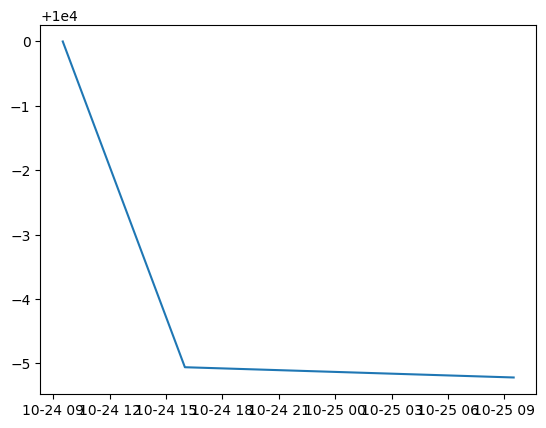

In [559]:
def backtest(stock_prices,spy_prices, stock_pred, timeframe, sizing_strategy,current_pos=10000):
    spy_series = convert_to_price_series(spy_prices.copy(),additional_columns=[])
    stock_series = convert_to_price_series(stock_prices.copy(),additional_columns=['beta'])




    series = stock_series.join(spy_series,lsuffix='_stock',rsuffix='_spy')
    stock_pred = stock_pred[stock_pred.index >= series.index[0]].copy()
    if stock_pred.empty:
        return None


    enter_idx = series.index.searchsorted(stock_pred.index)
    leave_idx = series.index.searchsorted(stock_pred.index + timeframe)
    idx_size = enter_idx.size

    # can not trade on the same time
    leave_idx[leave_idx == enter_idx] += 1



    output = []
    open_idx = None
    trade_id = 0
    shares = None
    direction = None
    idx = 0
    event = None
    for date, row in series.iterrows():
        #print(trade_id)
        if trade_id < idx_size and idx == enter_idx[trade_id]:
            assert open_idx is None
            open_idx = idx
            event = "opening"
            direction = stock_pred.iloc[trade_id]['direction']
            shares = sizing_strategy(current_pos, row['price_stock'], row['price_spy'], row['beta'])
            output.append([
                date,
                trade_id,
                idx,
                event,
                current_pos,
                0,
                direction,
                stock_pred.iloc[trade_id][model],
                shares,
                row['price_stock'],
                row['price_spy'],
                row['beta'],
            ])

        elif trade_id < idx_size and idx == leave_idx[trade_id]:
            assert open_idx is not None, f"trade_id: {trade_id}, idx: {idx}, open_idx: {open_idx}"
            change = direction*shares*(row['price_stock'] - series.iloc[open_idx]['price_stock'] - series.iloc[open_idx]['beta']* (row['price_spy'] - series.iloc[open_idx]['price_spy']))
            current_pos += change
            event = "closing"

            output.append([
                date,
                trade_id,
                idx,
                event,
                current_pos,
                change,
                direction,
                stock_pred.iloc[trade_id][model],
                shares,
                row['price_stock'],
                row['price_spy'],
                row['beta'],
            ])




            open_idx = None
            shares = None
            direction = None
            trade_id += 1
            
            # close position
        elif open_idx is not None:
            event = "holding"
            change = direction*shares*(row['price_stock'] - series.iloc[open_idx]['price_stock'] - series.iloc[open_idx]['beta']* (row['price_spy'] - series.iloc[open_idx]['price_spy']))

            output.append([
                date,
                trade_id,
                idx,
                event,
                current_pos + change,
                change,
                direction,
                stock_pred.iloc[trade_id][model],
                shares,
                row['price_stock'],
                row['price_spy'],
                row['beta'],
            ])



            pass
            # we have in the middle of open position
        else:
            event = "waiting"

        idx+=1

    output = pd.DataFrame(output,columns=['date','trade_id','idx','event','current_pos','change','direction','score','shares','price_stock','price_spy','beta']).set_index('date')
    # find index of wirst current_pos < 0
    first_neg = output['current_pos'] < 0
    if first_neg.any():
        output = output.loc[:output[first_neg].index[0]].copy()

    # calculate metrics

    
    return output



symbol="AMGN"
# AMZN openai/gpt-4o
# add filter by strategy
stock_pred = stocks_predictions_numbers[symbol]
# filter by model
model = "openai/o1-mini"
stock_pred = stock_pred[[model]].copy()
# direction is just sign of the number


# drop zeros
stock_pred['direction'] = stock_pred[model].dropna().astype(int).map({
    -2: -1,
    -1: np.nan,
    0: np.nan,
    1: np.nan,
    2: 1
})
# filter nans
stock_pred = stock_pred.sort_index().dropna()
display(stock_pred)

# different timeframes
timeframe = pd.Timedelta(days=1)

def sizing_strategy(current_pos, price_stock, price_spy, beta):
    return 10#current_pos/price_stock


output = backtest(prices[symbol],spy_prices, stock_pred, timeframe, sizing_strategy,current_pos=10000)
display(output)


to_plot = output#.iloc[:9]
# plot current_pos
# plot price_stock on separate y axis

import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
ax1.plot(to_plot.index, to_plot['current_pos'])
#ax2 = ax1.twinx() 

#ax2.plot(to_plot.index, to_plot['price_spy'],color='red')
plt.show()



In [561]:
def calculate_metrics(output):
    output = output.copy()
    openning = output[output['event'] == 'opening'].reset_index()
    clossing = output[output['event'] == 'closing'].reset_index()
    combined = openning.merge(clossing, on='trade_id',suffixes=('_open','_close'))
    wins = (clossing['change'] > 0).sum()
    n_trades = output['trade_id'].max() + 1

    trading_length = (combined['date_close'] - combined['date_open']).astype('timedelta64[s]').astype(int)/3600
    rets = np.log(combined['current_pos_close']/combined['current_pos_open'])/trading_length*24
    sharp = rets.mean()/rets.std()*np.sqrt(252)

    total_ret = np.log(output['current_pos'].iloc[-1]/output['current_pos'].iloc[0])

    #return sharp, wins, n_trades, wins/n_trades,total_ret*100, rets.std()*np.sqrt(252)
    series_output =  pd.Series(
        {
            'sharp': sharp,
            'wins': wins,
            'n_trades': n_trades,
            'win_ratio': wins/n_trades,
            'total_ret': total_ret*100,
            'vol': rets.std()*np.sqrt(252),
            'start_pos': output['current_pos'].iloc[0],
            'end_pos': output['current_pos'].iloc[-1],
            'earned': output['current_pos'].iloc[-1] - output['current_pos'].iloc[0],
        }
    )
    return series_output

calculate_metrics(output)

sharp                 NaN
wins             0.000000
n_trades         1.000000
win_ratio        0.000000
total_ret       -0.052197
vol                   NaN
start_pos    10000.000000
end_pos       9994.781668
earned          -5.218332
dtype: float64

In [616]:
import itertools

output = []
periods = [1,3,5]
trade_signals = ["aggresive","conservative"]

def sizing_strategy_abs(current_pos, price_stock, price_spy, beta):
        return 10
def sizing_strategy_rel(current_pos, price_stock, price_spy, beta):
    return current_pos/price_stock

sizings = ["absolute","relative"]
all_metrics = {}
prev_symbol = None
for symbol, model, period, trade_signal,sizing_name in itertools.product(profiles.keys(),MODELS.keys(),periods,trade_signals,sizings):
    if prev_symbol != symbol:
        print(symbol)
        prev_symbol = symbol
    timeframe = pd.Timedelta(days=period)
    stock_pred = stocks_predictions_numbers[symbol]

    stock_pred = stock_pred[[model]].copy()
    # direction is just sign of the number


    # drop zeros
    stock_pred['direction'] = stock_pred[model].dropna().astype(int).map({
        -2: -1,
        -1: -1 if trade_signal == "aggresive" else np.nan,
        0: np.nan,
        1: 1 if trade_signal == "aggresive" else np.nan,
        2: 1
    })
    # filter nans
    stock_pred = stock_pred.sort_index().dropna()
    if stock_pred.empty:
        continue

    sizing_strategy = sizing_strategy_abs if sizing_name == "absolute" else sizing_strategy_rel

    result = backtest(prices[symbol].copy(),spy_prices.copy(), stock_pred.copy(), timeframe, sizing_strategy,current_pos=10000)
    if result is None:
        continue
    result.to_csv(f"data/{symbol}/trading_{MODELS[model]}_{period}_{trade_signal}_{sizing_name}.csv")
    metrics = calculate_metrics(result)
    x = pd.concat([metrics,pd.Series({
        'symbol': symbol,
        'model': model,
        'period': period,
        'trade_signal': trade_signal,
        'sizing': sizing_name,
    })])
    output.append(x)


backtest_results = pd.concat(output,axis=1).T
backtest_results.to_csv("data/backtest_results.csv",index=False)

MMM
AXP
AMGN
AMZN


/tmp/ipykernel_221363/3635600322.py:13: RuntimeWarning: invalid value encountered in log
  total_ret = np.log(output['current_pos'].iloc[-1]/output['current_pos'].iloc[0])
/tmp/ipykernel_221363/3635600322.py:13: RuntimeWarning: invalid value encountered in log
  total_ret = np.log(output['current_pos'].iloc[-1]/output['current_pos'].iloc[0])
/tmp/ipykernel_221363/3635600322.py:13: RuntimeWarning: invalid value encountered in log
  total_ret = np.log(output['current_pos'].iloc[-1]/output['current_pos'].iloc[0])
/tmp/ipykernel_221363/3635600322.py:13: RuntimeWarning: invalid value encountered in log
  total_ret = np.log(output['current_pos'].iloc[-1]/output['current_pos'].iloc[0])
/tmp/ipykernel_221363/3635600322.py:13: RuntimeWarning: invalid value encountered in log
  total_ret = np.log(output['current_pos'].iloc[-1]/output['current_pos'].iloc[0])
/tmp/ipykernel_221363/3635600322.py:13: RuntimeWarning: invalid value encountered in log
  total_ret = np.log(output['current_pos'].iloc[-1]

AAPL


/tmp/ipykernel_221363/3635600322.py:13: RuntimeWarning: invalid value encountered in log
  total_ret = np.log(output['current_pos'].iloc[-1]/output['current_pos'].iloc[0])
/tmp/ipykernel_221363/3635600322.py:13: RuntimeWarning: invalid value encountered in log
  total_ret = np.log(output['current_pos'].iloc[-1]/output['current_pos'].iloc[0])
/tmp/ipykernel_221363/3635600322.py:13: RuntimeWarning: invalid value encountered in log
  total_ret = np.log(output['current_pos'].iloc[-1]/output['current_pos'].iloc[0])
/tmp/ipykernel_221363/3635600322.py:13: RuntimeWarning: invalid value encountered in log
  total_ret = np.log(output['current_pos'].iloc[-1]/output['current_pos'].iloc[0])
/tmp/ipykernel_221363/3635600322.py:13: RuntimeWarning: invalid value encountered in log
  total_ret = np.log(output['current_pos'].iloc[-1]/output['current_pos'].iloc[0])
/tmp/ipykernel_221363/3635600322.py:13: RuntimeWarning: invalid value encountered in log
  total_ret = np.log(output['current_pos'].iloc[-1]

BA
CAT
CVX
CSCO
KO
DIS
GS
HD
HON
IBM
JNJ
JPM
MCD
MRK
MSFT
NKE
NVDA


/home/lukaskiss/Documents/postfiat/venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_221363/3635600322.py:13: RuntimeWarning: invalid value encountered in log
  total_ret = np.log(output['current_pos'].iloc[-1]/output['current_pos'].iloc[0])
/tmp/ipykernel_221363/3635600322.py:13: RuntimeWarning: invalid value encountered in log
  total_ret = np.log(output['current_pos'].iloc[-1]/output['current_pos'].iloc[0])
/home/lukaskiss/Documents/postfiat/venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_221363/3635600322.py:13: RuntimeWarning: invalid value encountered in log
  total_ret = np.log(output['current_pos'].iloc[-1]/output['current_pos'].iloc[0])
/tmp/ipykernel_221363/3635600322.py:13: RuntimeWarning: invalid value encountered 

PG
CRM
SHW
TRV
UNH
VZ
V
WMT


In [620]:
backtest_results.sort_values(by='earned',ascending=False)

,sharp,wins,n_trades,win_ratio,total_ret,vol,start_pos,end_pos,earned,symbol,model,period,trade_signal,sizing
215,5.929952,15.0,25.0,0.6,293.72933,1.002693,10000.0,188647.160897,178647.160897,AMZN,perplexity/llama-3.1-sonar-large-128k-online,5,conservative,relative
479,3.29885,37.0,73.0,0.506849,158.97754,0.380775,10000.0,49026.476849,39026.476849,CSCO,openai/o1-mini,3,aggresive,relative
223,0.06668,13.0,23.0,0.565217,129.954565,1.968518,10000.0,36676.298956,26676.298956,AMZN,google/gemini-flash-1.5-8b,3,conservative,relative
483,2.414038,40.0,73.0,0.547945,127.344385,0.373277,10000.0,35731.367369,25731.367369,CSCO,openai/o1-mini,5,aggresive,relative
475,3.296778,41.0,73.0,0.561644,116.343837,1.176333,10000.0,32009.203332,22009.203332,CSCO,openai/o1-mini,1,aggresive,relative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1259,12.154848,3.0,4.0,0.75,NaN,45.345882,10000.0,-1915538.967052,-1925538.967052,NVDA,perplexity/llama-3.1-sonar-large-128k-online,3,aggresive,relative
1275,23.732311,3.0,4.0,0.75,NaN,3.116944,10000.0,-2295214.394103,-2305214.394103,NVDA,google/gemini-flash-1.5-8b,5,aggresive,relative
1251,23.732311,3.0,4.0,0.75,NaN,3.116944,10000.0,-2295214.394103,-2305214.394103,NVDA,openai/o1-mini,5,aggresive,relative
1263,23.732311,3.0,4.0,0.75,NaN,3.116944,10000.0,-2295214.394103,-2305214.394103,NVDA,perplexity/llama-3.1-sonar-large-128k-online,5,aggresive,relative


In [637]:
x = backtest_results[backtest_results['total_ret'].isna()]
x[x['symbol']=='AMZN']

,sharp,wins,n_trades,win_ratio,total_ret,vol,start_pos,end_pos,earned,symbol,model,period,trade_signal,sizing
189,7.447415,6.0,9.0,0.666667,NaN,1.966105,10000.0,-17670.406981,-27670.406981,AMZN,openai/gpt-4o,5,aggresive,relative
193,-3.497346,5.0,12.0,0.416667,NaN,11.093546,10000.0,-1184.445043,-11184.445043,AMZN,openai/o1-mini,1,aggresive,relative
197,-1.261954,7.0,12.0,0.583333,NaN,3.216224,10000.0,-14686.360076,-24686.360076,AMZN,openai/o1-mini,3,aggresive,relative
201,10.282042,9.0,12.0,0.75,NaN,1.754528,10000.0,-401327.427437,-411327.427437,AMZN,openai/o1-mini,5,aggresive,relative
205,-3.497346,5.0,12.0,0.416667,NaN,11.093546,10000.0,-1184.445043,-11184.445043,AMZN,perplexity/llama-3.1-sonar-large-128k-online,1,aggresive,relative
209,-1.261954,7.0,12.0,0.583333,NaN,3.216224,10000.0,-14686.360076,-24686.360076,AMZN,perplexity/llama-3.1-sonar-large-128k-online,3,aggresive,relative
213,10.282042,9.0,12.0,0.75,NaN,1.754528,10000.0,-401327.427437,-411327.427437,AMZN,perplexity/llama-3.1-sonar-large-128k-online,5,aggresive,relative
217,-5.753539,4.0,11.0,0.363636,NaN,14.840131,10000.0,-217.536463,-10217.536463,AMZN,google/gemini-flash-1.5-8b,1,aggresive,relative
221,23.063449,2.0,3.0,0.666667,NaN,0.958503,10000.0,-13973.611025,-23973.611025,AMZN,google/gemini-flash-1.5-8b,3,aggresive,relative
225,83.176176,2.0,3.0,0.666667,NaN,0.348148,10000.0,-20067.503706,-30067.503706,AMZN,google/gemini-flash-1.5-8b,5,aggresive,relative


In [612]:
# absolute only
df = backtest_results[backtest_results['sizing'] == 'absolute']
df.sort_values(by='earned',ascending=False)

,sharp,wins,n_trades,win_ratio,total_ret,vol,start_pos,end_pos,earned,symbol,model,period,trade_signal,sizing
128,3.12473,38.0,63.0,0.603175,8.650513,0.021706,10000.0,10903.569576,903.569576,AMGN,openai/gpt-4o,5,aggresive,absolute
164,2.759588,42.0,73.0,0.575342,8.467871,0.020689,10000.0,10883.673316,883.673316,AMGN,google/gemini-flash-1.5-8b,5,aggresive,absolute
152,2.835492,42.0,71.0,0.591549,8.043674,0.019596,10000.0,10837.602839,837.602839,AMGN,perplexity/llama-3.1-sonar-large-128k-online,5,aggresive,absolute
1570,3.821487,24.0,40.0,0.6,8.039604,0.044606,10000.0,10837.161777,837.161777,UNH,mistralai/ministral-8b,3,aggresive,absolute
1566,6.050082,27.0,40.0,0.675,7.914738,0.08784,10000.0,10823.638325,823.638325,UNH,mistralai/ministral-8b,1,aggresive,absolute
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1384,-8.289187,13.0,38.0,0.342105,-16.387034,0.02605,10000.0,8488.52073,-1511.47927,CRM,perplexity/llama-3.1-sonar-large-128k-online,5,conservative,absolute
1370,-5.824046,21.0,59.0,0.355932,-16.827526,0.024652,10000.0,8451.211732,-1548.788268,CRM,openai/o1-mini,5,aggresive,absolute
1262,-4.885399,30.0,74.0,0.405405,-17.193363,0.024043,10000.0,8420.350605,-1579.649395,NVDA,perplexity/llama-3.1-sonar-large-128k-online,5,aggresive,absolute
1378,-7.554191,17.0,59.0,0.288136,-18.462243,0.027089,10000.0,8314.181454,-1685.818546,CRM,perplexity/llama-3.1-sonar-large-128k-online,3,aggresive,absolute


In [644]:
period = 5
df = backtest_results[(backtest_results['period'] == period) & (backtest_results['n_trades'] >= 0)]
# aggresive sizing
#df = df[df['sizing'] == "absolute"]

for symbol in profiles.keys():
    print(symbol)
    display(df[df['symbol'] == symbol].sort_values(by='earned',ascending=False))
    print()

MMM


,sharp,wins,n_trades,win_ratio,total_ret,vol,start_pos,end_pos,earned,symbol,model,period,trade_signal,sizing
33,3.718737,38.0,63.0,0.603175,46.243265,0.09189,10000.0,15879.321722,5879.321722,MMM,perplexity/llama-3.1-sonar-large-128k-online,5,aggresive,relative
45,2.512713,35.0,66.0,0.530303,33.584828,0.092185,10000.0,13991.267336,3991.267336,MMM,google/gemini-flash-1.5-8b,5,aggresive,relative
21,1.943492,40.0,68.0,0.588235,28.122675,0.092232,10000.0,13247.539623,3247.539623,MMM,openai/o1-mini,5,aggresive,relative
57,2.451021,27.0,49.0,0.55102,24.295805,0.086009,10000.0,12750.15132,2750.15132,MMM,mistralai/ministral-8b,5,aggresive,relative
9,0.855986,25.0,46.0,0.543478,7.952628,0.096286,10000.0,10827.740154,827.740154,MMM,openai/gpt-4o,5,aggresive,relative
32,4.023092,38.0,63.0,0.603175,5.65769,0.010245,10000.0,10582.079868,582.079868,MMM,perplexity/llama-3.1-sonar-large-128k-online,5,aggresive,absolute
44,3.012687,35.0,66.0,0.530303,4.588249,0.010451,10000.0,10469.513793,469.513793,MMM,google/gemini-flash-1.5-8b,5,aggresive,absolute
56,4.215609,27.0,49.0,0.55102,4.016928,0.008686,10000.0,10409.869803,409.869803,MMM,mistralai/ministral-8b,5,aggresive,absolute
20,2.329677,40.0,68.0,0.588235,3.699955,0.010489,10000.0,10376.925563,376.925563,MMM,openai/o1-mini,5,aggresive,absolute
11,3.022245,4.0,5.0,0.8,2.90215,0.082105,10000.0,10294.467248,294.467248,MMM,openai/gpt-4o,5,conservative,relative



AXP


,sharp,wins,n_trades,win_ratio,total_ret,vol,start_pos,end_pos,earned,symbol,model,period,trade_signal,sizing
117,0.951851,27.0,51.0,0.529412,22.282232,0.162027,10000.0,12495.985306,2495.985306,AXP,mistralai/ministral-8b,5,aggresive,relative
95,1.687516,4.0,7.0,0.571429,3.350683,0.142961,10000.0,10340.745081,340.745081,AXP,perplexity/llama-3.1-sonar-large-128k-online,5,conservative,relative
92,1.202992,37.0,67.0,0.552239,2.339376,0.014207,10000.0,10236.695413,236.695413,AXP,perplexity/llama-3.1-sonar-large-128k-online,5,aggresive,absolute
68,0.664234,26.0,51.0,0.509804,1.106221,0.016064,10000.0,10111.23622,111.23622,AXP,openai/gpt-4o,5,aggresive,absolute
118,0.6282,6.0,8.0,0.75,0.108538,0.018345,10000.0,10010.859673,10.859673,AXP,mistralai/ministral-8b,5,conservative,absolute
82,-9.148906,1.0,2.0,0.5,-0.094988,0.002616,10000.0,9990.505708,-9.494292,AXP,openai/o1-mini,5,conservative,absolute
94,-0.385313,4.0,7.0,0.571429,-0.116104,0.021695,10000.0,9988.396332,-11.603668,AXP,perplexity/llama-3.1-sonar-large-128k-online,5,conservative,absolute
119,0.193005,6.0,8.0,0.75,-0.129841,0.09849,10000.0,9987.024315,-12.975685,AXP,mistralai/ministral-8b,5,conservative,relative
104,-0.42938,33.0,68.0,0.485294,-0.368154,0.01461,10000.0,9963.252334,-36.747666,AXP,google/gemini-flash-1.5-8b,5,aggresive,absolute
70,NaN,0.0,1.0,0.0,-0.903064,NaN,10000.0,9910.100138,-89.899862,AXP,openai/gpt-4o,5,conservative,absolute



AMGN


,sharp,wins,n_trades,win_ratio,total_ret,vol,start_pos,end_pos,earned,symbol,model,period,trade_signal,sizing
129,3.4685,38.0,63.0,0.603175,48.331184,0.11331,10000.0,16214.354507,6214.354507,AMGN,openai/gpt-4o,5,aggresive,relative
153,3.314237,42.0,71.0,0.591549,47.431645,0.101577,10000.0,16069.154154,6069.154154,AMGN,perplexity/llama-3.1-sonar-large-128k-online,5,aggresive,relative
165,2.559251,42.0,73.0,0.575342,40.712227,0.110902,10000.0,15024.878054,5024.878054,AMGN,google/gemini-flash-1.5-8b,5,aggresive,relative
141,2.66158,35.0,66.0,0.530303,38.125696,0.114187,10000.0,14641.237801,4641.237801,AMGN,openai/o1-mini,5,aggresive,relative
177,1.239676,35.0,59.0,0.59322,16.930872,0.118006,10000.0,11844.857532,1844.857532,AMGN,mistralai/ministral-8b,5,aggresive,relative
179,10.887194,4.0,5.0,0.8,9.607964,0.088956,10000.0,11008.467294,1008.467294,AMGN,mistralai/ministral-8b,5,conservative,relative
128,3.12473,38.0,63.0,0.603175,8.650513,0.021706,10000.0,10903.569576,903.569576,AMGN,openai/gpt-4o,5,aggresive,absolute
164,2.759588,42.0,73.0,0.575342,8.467871,0.020689,10000.0,10883.673316,883.673316,AMGN,google/gemini-flash-1.5-8b,5,aggresive,absolute
152,2.835492,42.0,71.0,0.591549,8.043674,0.019596,10000.0,10837.602839,837.602839,AMGN,perplexity/llama-3.1-sonar-large-128k-online,5,aggresive,absolute
140,2.407344,35.0,66.0,0.530303,6.914877,0.021837,10000.0,10715.956164,715.956164,AMGN,openai/o1-mini,5,aggresive,absolute



AMZN


,sharp,wins,n_trades,win_ratio,total_ret,vol,start_pos,end_pos,earned,symbol,model,period,trade_signal,sizing
215,5.929952,15.0,25.0,0.6,293.72933,1.002693,10000.0,188647.160897,178647.160897,AMZN,perplexity/llama-3.1-sonar-large-128k-online,5,conservative,relative
227,2.99191,10.0,23.0,0.434783,115.378309,0.852616,10000.0,31701.63268,21701.63268,AMZN,google/gemini-flash-1.5-8b,5,conservative,relative
239,3.395472,3.0,8.0,0.375,32.186632,0.599349,10000.0,13797.003301,3797.003301,AMZN,mistralai/ministral-8b,5,conservative,relative
190,-10.322238,1.0,2.0,0.5,-0.657995,0.016064,10000.0,9934.416542,-65.583458,AMZN,openai/gpt-4o,5,conservative,absolute
202,-7.543759,2.0,4.0,0.5,-0.824871,0.015156,10000.0,9917.852125,-82.147875,AMZN,openai/o1-mini,5,conservative,absolute
238,-8.232558,3.0,8.0,0.375,-1.729364,0.013071,10000.0,9828.550372,-171.449628,AMZN,mistralai/ministral-8b,5,conservative,absolute
214,-2.907566,15.0,25.0,0.6,-3.417033,0.023223,10000.0,9664.068838,-335.931162,AMZN,perplexity/llama-3.1-sonar-large-128k-online,5,conservative,absolute
212,-2.425765,37.0,74.0,0.5,-5.526837,0.017331,10000.0,9462.311752,-537.688248,AMZN,perplexity/llama-3.1-sonar-large-128k-online,5,aggresive,absolute
226,-4.75388,10.0,23.0,0.434783,-5.612464,0.025526,10000.0,9454.212937,-545.787063,AMZN,google/gemini-flash-1.5-8b,5,conservative,absolute
191,-9.590514,1.0,2.0,0.5,-6.365356,0.167256,10000.0,9383.300224,-616.699776,AMZN,openai/gpt-4o,5,conservative,relative



AAPL


,sharp,wins,n_trades,win_ratio,total_ret,vol,start_pos,end_pos,earned,symbol,model,period,trade_signal,sizing
298,1.228945,10.0,18.0,0.555556,1.11359,0.0237,10000.0,10111.981392,111.981392,AAPL,mistralai/ministral-8b,5,conservative,absolute
250,0.313116,4.0,14.0,0.285714,-0.020769,0.013245,10000.0,9997.923346,-2.076654,AAPL,openai/gpt-4o,5,conservative,absolute
296,-0.700953,29.0,65.0,0.446154,-1.39525,0.01573,10000.0,9861.443849,-138.556151,AAPL,mistralai/ministral-8b,5,aggresive,absolute
262,-8.086496,4.0,13.0,0.307692,-2.291829,0.011064,10000.0,9773.423379,-226.576621,AAPL,openai/o1-mini,5,conservative,absolute
286,-2.088762,19.0,46.0,0.413043,-3.242426,0.016332,10000.0,9680.957706,-319.042294,AAPL,google/gemini-flash-1.5-8b,5,conservative,absolute
274,-3.823629,8.0,27.0,0.296296,-3.716505,0.017328,10000.0,9635.170945,-364.829055,AAPL,perplexity/llama-3.1-sonar-large-128k-online,5,conservative,absolute
272,-1.737196,31.0,74.0,0.418919,-4.396578,0.01676,10000.0,9569.867031,-430.132969,AAPL,perplexity/llama-3.1-sonar-large-128k-online,5,aggresive,absolute
284,-1.90874,33.0,75.0,0.44,-4.933104,0.016938,10000.0,9518.659748,-481.340252,AAPL,google/gemini-flash-1.5-8b,5,aggresive,absolute
260,-2.237851,30.0,75.0,0.4,-5.792144,0.017026,10000.0,9437.240831,-562.759169,AAPL,openai/o1-mini,5,aggresive,absolute
248,-3.013605,27.0,72.0,0.375,-7.384642,0.016869,10000.0,9288.143317,-711.856683,AAPL,openai/gpt-4o,5,aggresive,absolute



BA


,sharp,wins,n_trades,win_ratio,total_ret,vol,start_pos,end_pos,earned,symbol,model,period,trade_signal,sizing
339,1.148112,36.0,71.0,0.507042,18.340569,0.118148,10000.0,12013.016606,2013.016606,BA,google/gemini-flash-1.5-8b,5,aggresive,relative
329,4.635029,10.0,17.0,0.588235,17.353136,0.110996,10000.0,11894.979854,1894.979854,BA,perplexity/llama-3.1-sonar-large-128k-online,5,conservative,relative
338,2.083964,36.0,71.0,0.507042,6.006396,0.020647,10000.0,10619.0446,619.0446,BA,google/gemini-flash-1.5-8b,5,aggresive,absolute
328,4.750039,10.0,17.0,0.588235,4.134255,0.025804,10000.0,10422.090535,422.090535,BA,perplexity/llama-3.1-sonar-large-128k-online,5,conservative,absolute
317,NaN,1.0,1.0,1.0,2.810083,NaN,10000.0,10284.993866,284.993866,BA,openai/o1-mini,5,conservative,relative
350,0.886747,28.0,63.0,0.444444,2.592289,0.023894,10000.0,10262.61814,262.61814,BA,mistralai/ministral-8b,5,aggresive,absolute
340,2.748718,9.0,16.0,0.5625,1.759472,0.020163,10000.0,10177.504227,177.504227,BA,google/gemini-flash-1.5-8b,5,conservative,absolute
326,0.479923,28.0,65.0,0.430769,1.421334,0.023863,10000.0,10143.148345,143.148345,BA,perplexity/llama-3.1-sonar-large-128k-online,5,aggresive,absolute
316,NaN,1.0,1.0,1.0,0.673533,NaN,10000.0,10067.580595,67.580595,BA,openai/o1-mini,5,conservative,absolute
341,0.060975,9.0,16.0,0.5625,0.300958,0.155477,10000.0,10030.141136,30.141136,BA,google/gemini-flash-1.5-8b,5,conservative,relative



CAT


,sharp,wins,n_trades,win_ratio,total_ret,vol,start_pos,end_pos,earned,symbol,model,period,trade_signal,sizing
411,0.409169,30.0,59.0,0.508475,5.097324,0.090194,10000.0,10522.947364,522.947364,CAT,mistralai/ministral-8b,5,aggresive,relative
413,6.319902,3.0,5.0,0.6,4.556753,0.074025,10000.0,10466.216797,466.216797,CAT,mistralai/ministral-8b,5,conservative,relative
410,1.366754,30.0,59.0,0.508475,2.139002,0.014066,10000.0,10216.204226,216.204226,CAT,mistralai/ministral-8b,5,aggresive,absolute
412,7.043894,3.0,5.0,0.6,1.131071,0.016378,10000.0,10113.749216,113.749216,CAT,mistralai/ministral-8b,5,conservative,absolute
376,-32.158553,0.0,3.0,0.0,-0.760106,0.003869,10000.0,9924.277558,-75.722442,CAT,openai/o1-mini,5,conservative,absolute
398,-0.077084,31.0,67.0,0.462687,-0.769119,0.013651,10000.0,9923.383122,-76.616878,CAT,google/gemini-flash-1.5-8b,5,aggresive,absolute
388,-12.320032,3.0,12.0,0.25,-2.14592,0.006656,10000.0,9787.694116,-212.305884,CAT,perplexity/llama-3.1-sonar-large-128k-online,5,conservative,absolute
364,-11.405939,2.0,6.0,0.333333,-2.327817,0.013733,10000.0,9769.90679,-230.09321,CAT,openai/gpt-4o,5,conservative,absolute
400,-6.594686,7.0,17.0,0.411765,-2.757086,0.009851,10000.0,9728.057444,-271.942556,CAT,google/gemini-flash-1.5-8b,5,conservative,absolute
399,0.047832,31.0,67.0,0.462687,-2.89335,0.083942,10000.0,9714.810687,-285.189313,CAT,google/gemini-flash-1.5-8b,5,aggresive,relative



CVX


,sharp,wins,n_trades,win_ratio,total_ret,vol,start_pos,end_pos,earned,symbol,model,period,trade_signal,sizing
461,3.762291,3.0,7.0,0.428571,3.060431,0.114099,10000.0,10310.774386,310.774386,CVX,mistralai/ministral-8b,5,conservative,relative
460,2.383642,3.0,7.0,0.428571,0.202535,0.012271,10000.0,10020.274055,20.274055,CVX,mistralai/ministral-8b,5,conservative,absolute
436,-5.125861,2.0,5.0,0.4,-0.319267,0.010464,10000.0,9968.124222,-31.875778,CVX,perplexity/llama-3.1-sonar-large-128k-online,5,conservative,absolute
448,-1.317439,11.0,18.0,0.611111,-1.429644,0.018035,10000.0,9858.052732,-141.947268,CVX,google/gemini-flash-1.5-8b,5,conservative,absolute
446,-1.739439,36.0,66.0,0.545455,-3.790526,0.01985,10000.0,9628.041483,-371.958517,CVX,google/gemini-flash-1.5-8b,5,aggresive,absolute
437,-6.245082,2.0,5.0,0.4,-4.183255,0.112534,10000.0,9590.303565,-409.696435,CVX,perplexity/llama-3.1-sonar-large-128k-online,5,conservative,relative
434,-2.189543,32.0,62.0,0.516129,-4.584828,0.020219,10000.0,9551.868683,-448.131317,CVX,perplexity/llama-3.1-sonar-large-128k-online,5,aggresive,absolute
424,-2.164496,33.0,65.0,0.507692,-4.80788,0.019827,10000.0,9530.58682,-469.41318,CVX,openai/o1-mini,5,aggresive,absolute
458,-2.878834,22.0,54.0,0.407407,-4.984762,0.021521,10000.0,9513.743876,-486.256124,CVX,mistralai/ministral-8b,5,aggresive,absolute
449,-0.231554,11.0,18.0,0.611111,-7.086539,0.148723,10000.0,9315.872818,-684.127182,CVX,google/gemini-flash-1.5-8b,5,conservative,relative



CSCO


,sharp,wins,n_trades,win_ratio,total_ret,vol,start_pos,end_pos,earned,symbol,model,period,trade_signal,sizing
483,2.414038,40.0,73.0,0.547945,127.344385,0.373277,10000.0,35731.367369,25731.367369,CSCO,openai/o1-mini,5,aggresive,relative
509,5.185547,10.0,17.0,0.588235,54.364851,0.310817,10000.0,17222.79162,7222.79162,CSCO,google/gemini-flash-1.5-8b,5,conservative,relative
471,1.335783,33.0,61.0,0.540984,51.46068,0.337928,10000.0,16729.805565,6729.805565,CSCO,openai/gpt-4o,5,aggresive,relative
473,21.039265,5.0,6.0,0.833333,40.520951,0.161781,10000.0,14996.166548,4996.166548,CSCO,openai/gpt-4o,5,conservative,relative
497,7.037599,9.0,14.0,0.642857,39.416402,0.20163,10000.0,14831.437959,4831.437959,CSCO,perplexity/llama-3.1-sonar-large-128k-online,5,conservative,relative
485,11.281946,3.0,4.0,0.75,16.66431,0.186112,10000.0,11813.32576,1813.32576,CSCO,openai/o1-mini,5,conservative,relative
482,3.747281,40.0,73.0,0.547945,6.807991,0.01265,10000.0,10704.508428,704.508428,CSCO,openai/o1-mini,5,aggresive,absolute
518,2.453618,34.0,64.0,0.53125,3.793253,0.012363,10000.0,10386.611558,386.611558,CSCO,mistralai/ministral-8b,5,aggresive,absolute
470,2.390269,33.0,61.0,0.540984,3.407012,0.011979,10000.0,10346.571493,346.571493,CSCO,openai/gpt-4o,5,aggresive,absolute
508,5.91787,10.0,17.0,0.588235,2.160892,0.010826,10000.0,10218.440846,218.440846,CSCO,google/gemini-flash-1.5-8b,5,conservative,absolute



KO


,sharp,wins,n_trades,win_ratio,total_ret,vol,start_pos,end_pos,earned,symbol,model,period,trade_signal,sizing
575,2.00012,4.0,8.0,0.5,12.058375,0.214151,10000.0,11281.552207,1281.552207,KO,mistralai/ministral-8b,5,conservative,relative
574,3.313602,4.0,8.0,0.5,1.063001,0.01284,10000.0,10106.867134,106.867134,KO,mistralai/ministral-8b,5,conservative,absolute
548,0.028024,26.0,68.0,0.382353,0.268508,0.008906,10000.0,10026.886878,26.886878,KO,perplexity/llama-3.1-sonar-large-128k-online,5,aggresive,absolute
562,0.209817,3.0,9.0,0.333333,0.208803,0.011519,10000.0,10020.902117,20.902117,KO,google/gemini-flash-1.5-8b,5,conservative,absolute
538,NaN,0.0,1.0,0.0,-0.076032,NaN,10000.0,9992.39966,-7.60034,KO,openai/o1-mini,5,conservative,absolute
572,-0.199095,22.0,52.0,0.423077,-0.139432,0.008659,10000.0,9986.066526,-13.933474,KO,mistralai/ministral-8b,5,aggresive,absolute
560,-0.951372,24.0,66.0,0.363636,-0.967291,0.008596,10000.0,9903.737178,-96.262822,KO,google/gemini-flash-1.5-8b,5,aggresive,absolute
536,-0.797367,25.0,65.0,0.384615,-0.96733,0.008491,10000.0,9903.73333,-96.26667,KO,openai/o1-mini,5,aggresive,absolute
550,-9.199705,2.0,9.0,0.222222,-1.056862,0.006401,10000.0,9894.870322,-105.129678,KO,perplexity/llama-3.1-sonar-large-128k-online,5,conservative,absolute
526,-1.507978,21.0,62.0,0.33871,-1.618496,0.008873,10000.0,9839.45317,-160.54683,KO,openai/gpt-4o,5,aggresive,absolute



DIS


,sharp,wins,n_trades,win_ratio,total_ret,vol,start_pos,end_pos,earned,symbol,model,period,trade_signal,sizing
611,0.240878,14.0,24.0,0.583333,1.77247,0.118446,10000.0,10178.827163,178.827163,DIS,perplexity/llama-3.1-sonar-large-128k-online,5,conservative,relative
610,2.419373,14.0,24.0,0.583333,1.203817,0.010127,10000.0,10121.109251,121.109251,DIS,perplexity/llama-3.1-sonar-large-128k-online,5,conservative,absolute
598,-2.978317,3.0,7.0,0.428571,-0.307953,0.00834,10000.0,9969.252071,-30.747929,DIS,openai/o1-mini,5,conservative,absolute
586,-8.497787,3.0,7.0,0.428571,-0.856988,0.007261,10000.0,9914.667394,-85.332606,DIS,openai/gpt-4o,5,conservative,absolute
634,-10.618652,3.0,12.0,0.25,-2.292246,0.009067,10000.0,9773.38262,-226.61738,DIS,mistralai/ministral-8b,5,conservative,absolute
622,-4.771131,13.0,27.0,0.481481,-2.615594,0.010378,10000.0,9741.831668,-258.168332,DIS,google/gemini-flash-1.5-8b,5,conservative,absolute
632,-1.507448,28.0,61.0,0.459016,-2.646025,0.015433,10000.0,9738.867544,-261.132456,DIS,mistralai/ministral-8b,5,aggresive,absolute
608,-2.14783,36.0,69.0,0.521739,-4.334393,0.014385,10000.0,9575.819884,-424.180116,DIS,perplexity/llama-3.1-sonar-large-128k-online,5,aggresive,absolute
584,-3.972913,29.0,57.0,0.508772,-6.869533,0.015076,10000.0,9336.1108,-663.8892,DIS,openai/gpt-4o,5,aggresive,absolute
596,-4.107088,31.0,63.0,0.492063,-7.596784,0.014585,10000.0,9268.460116,-731.539884,DIS,openai/o1-mini,5,aggresive,absolute



GS


,sharp,wins,n_trades,win_ratio,total_ret,vol,start_pos,end_pos,earned,symbol,model,period,trade_signal,sizing
675,0.9699,37.0,62.0,0.596774,9.815734,0.068604,10000.0,11031.36337,1031.36337,GS,google/gemini-flash-1.5-8b,5,aggresive,relative
677,5.1024,8.0,10.0,0.8,6.532755,0.052683,10000.0,10675.086243,675.086243,GS,google/gemini-flash-1.5-8b,5,conservative,relative
674,1.375754,37.0,62.0,0.596774,3.276089,0.015174,10000.0,10333.034414,333.034414,GS,google/gemini-flash-1.5-8b,5,aggresive,absolute
676,2.597684,8.0,10.0,0.8,1.261932,0.016949,10000.0,10126.992782,126.992782,GS,google/gemini-flash-1.5-8b,5,conservative,absolute
689,2.117743,7.0,10.0,0.7,1.123755,0.048586,10000.0,10113.009266,113.009266,GS,mistralai/ministral-8b,5,conservative,relative
653,62.065062,2.0,2.0,1.0,0.964105,0.003604,10000.0,10096.876754,96.876754,GS,openai/o1-mini,5,conservative,relative
652,186.420866,2.0,2.0,1.0,0.212501,0.000267,10000.0,10021.272649,21.272649,GS,openai/o1-mini,5,conservative,absolute
688,-0.35718,7.0,10.0,0.7,-0.232693,0.013777,10000.0,9976.757763,-23.242237,GS,mistralai/ministral-8b,5,conservative,absolute
650,-0.891011,31.0,64.0,0.484375,-1.063676,0.016211,10000.0,9894.196114,-105.803886,GS,openai/o1-mini,5,aggresive,absolute
640,-0.901878,27.0,48.0,0.5625,-1.073261,0.018636,10000.0,9893.247746,-106.752254,GS,openai/gpt-4o,5,aggresive,absolute



HD


,sharp,wins,n_trades,win_ratio,total_ret,vol,start_pos,end_pos,earned,symbol,model,period,trade_signal,sizing
749,3.939253,4.0,8.0,0.5,6.970685,0.097843,10000.0,10721.938255,721.938255,HD,mistralai/ministral-8b,5,conservative,relative
725,1.182104,10.0,20.0,0.5,5.42723,0.111246,10000.0,10557.720445,557.720445,HD,perplexity/llama-3.1-sonar-large-128k-online,5,conservative,relative
734,1.917667,34.0,68.0,0.5,3.590166,0.011583,10000.0,10365.539091,365.539091,HD,google/gemini-flash-1.5-8b,5,aggresive,absolute
722,1.731572,37.0,68.0,0.544118,2.898065,0.011057,10000.0,10294.046796,294.046796,HD,perplexity/llama-3.1-sonar-large-128k-online,5,aggresive,absolute
746,1.22367,31.0,66.0,0.469697,2.111416,0.01079,10000.0,10213.386458,213.386458,HD,mistralai/ministral-8b,5,aggresive,absolute
698,0.91568,33.0,66.0,0.5,1.513545,0.010879,10000.0,10152.505748,152.505748,HD,openai/gpt-4o,5,aggresive,absolute
701,1.863603,2.0,4.0,0.5,1.375666,0.081172,10000.0,10138.517195,138.517195,HD,openai/gpt-4o,5,conservative,relative
700,4.20457,2.0,4.0,0.5,0.985994,0.025787,10000.0,10099.087067,99.087067,HD,openai/gpt-4o,5,conservative,absolute
710,0.487238,37.0,71.0,0.521127,0.978461,0.011584,10000.0,10098.326317,98.326317,HD,openai/o1-mini,5,aggresive,absolute
736,1.422672,8.0,18.0,0.444444,0.806062,0.013769,10000.0,10080.931912,80.931912,HD,google/gemini-flash-1.5-8b,5,conservative,absolute



HON


,sharp,wins,n_trades,win_ratio,total_ret,vol,start_pos,end_pos,earned,symbol,model,period,trade_signal,sizing
773,3.913344,9.0,13.0,0.692308,13.091245,0.118752,10000.0,11398.679783,1398.679783,HON,openai/o1-mini,5,conservative,relative
759,0.742333,35.0,63.0,0.555556,6.966543,0.106486,10000.0,10721.494154,721.494154,HON,openai/gpt-4o,5,aggresive,relative
797,1.303311,12.0,23.0,0.521739,5.652095,0.117617,10000.0,10581.487802,581.487802,HON,google/gemini-flash-1.5-8b,5,conservative,relative
783,0.835561,37.0,69.0,0.536232,5.617095,0.107846,10000.0,10577.784936,577.784936,HON,perplexity/llama-3.1-sonar-large-128k-online,5,aggresive,relative
771,0.714772,36.0,68.0,0.529412,4.612096,0.10758,10000.0,10472.010721,472.010721,HON,openai/o1-mini,5,aggresive,relative
795,0.68817,37.0,70.0,0.528571,3.57056,0.107662,10000.0,10363.506995,363.506995,HON,google/gemini-flash-1.5-8b,5,aggresive,relative
761,9.271661,2.0,3.0,0.666667,1.579033,0.047686,10000.0,10159.156547,159.156547,HON,openai/gpt-4o,5,conservative,relative
772,4.904008,9.0,13.0,0.692308,1.271625,0.010167,10000.0,10127.974484,127.974484,HON,openai/o1-mini,5,conservative,absolute
760,13.067448,2.0,3.0,0.666667,0.145226,0.003112,10000.0,10014.533115,14.533115,HON,openai/gpt-4o,5,conservative,absolute
796,-0.561941,12.0,23.0,0.521739,-0.403864,0.012796,10000.0,9959.695082,-40.304918,HON,google/gemini-flash-1.5-8b,5,conservative,absolute



IBM


,sharp,wins,n_trades,win_ratio,total_ret,vol,start_pos,end_pos,earned,symbol,model,period,trade_signal,sizing
831,1.483341,41.0,69.0,0.594203,18.182825,0.107449,10000.0,11994.081811,1994.081811,IBM,openai/o1-mini,5,aggresive,relative
845,7.782972,10.0,16.0,0.625,10.257949,0.041221,10000.0,11080.253756,1080.253756,IBM,perplexity/llama-3.1-sonar-large-128k-online,5,conservative,relative
833,35.068002,3.0,3.0,1.0,8.578228,0.041096,10000.0,10895.690818,895.690818,IBM,openai/o1-mini,5,conservative,relative
830,1.951013,41.0,69.0,0.594203,3.541112,0.014589,10000.0,10360.455646,360.455646,IBM,openai/o1-mini,5,aggresive,absolute
869,2.303333,2.0,6.0,0.333333,3.154216,0.126163,10000.0,10320.448805,320.448805,IBM,mistralai/ministral-8b,5,conservative,relative
844,7.8867,10.0,16.0,0.625,1.505227,0.005932,10000.0,10151.661245,151.661245,IBM,perplexity/llama-3.1-sonar-large-128k-online,5,conservative,absolute
832,34.082487,3.0,3.0,1.0,1.196593,0.005898,10000.0,10120.378123,120.378123,IBM,openai/o1-mini,5,conservative,absolute
857,-0.028094,10.0,13.0,0.769231,0.675747,0.107079,10000.0,10067.80358,67.80358,IBM,google/gemini-flash-1.5-8b,5,conservative,relative
868,2.55321,2.0,6.0,0.333333,0.469839,0.016735,10000.0,10047.09448,47.09448,IBM,mistralai/ministral-8b,5,conservative,absolute
866,0.355838,32.0,60.0,0.533333,0.374449,0.017272,10000.0,10037.515091,37.515091,IBM,mistralai/ministral-8b,5,aggresive,absolute



JNJ


,sharp,wins,n_trades,win_ratio,total_ret,vol,start_pos,end_pos,earned,symbol,model,period,trade_signal,sizing
879,1.74029,23.0,48.0,0.479167,10.985616,0.058697,10000.0,11161.175206,1161.175206,JNJ,openai/gpt-4o,5,aggresive,relative
903,1.208373,31.0,65.0,0.476923,9.904815,0.061482,10000.0,11041.194641,1041.194641,JNJ,perplexity/llama-3.1-sonar-large-128k-online,5,aggresive,relative
891,1.028314,32.0,63.0,0.507937,9.195523,0.063627,10000.0,10963.15742,963.15742,JNJ,openai/o1-mini,5,aggresive,relative
927,1.256481,27.0,55.0,0.490909,8.055027,0.060533,10000.0,10838.833276,838.833276,JNJ,mistralai/ministral-8b,5,aggresive,relative
915,0.553848,31.0,66.0,0.469697,5.528668,0.062768,10000.0,10568.435452,568.435452,JNJ,google/gemini-flash-1.5-8b,5,aggresive,relative
917,4.110011,4.0,9.0,0.444444,5.185993,0.059372,10000.0,10532.282072,532.282072,JNJ,google/gemini-flash-1.5-8b,5,conservative,relative
881,NaN,1.0,1.0,1.0,4.404155,NaN,10000.0,10450.257745,450.257745,JNJ,openai/gpt-4o,5,conservative,relative
893,5.779074,1.0,2.0,0.5,2.993633,0.113925,10000.0,10303.889284,303.889284,JNJ,openai/o1-mini,5,conservative,relative
890,2.236673,32.0,63.0,0.507937,2.232858,0.007385,10000.0,10225.797288,225.797288,JNJ,openai/o1-mini,5,aggresive,absolute
902,1.933074,31.0,65.0,0.476923,1.928575,0.007266,10000.0,10194.729249,194.729249,JNJ,perplexity/llama-3.1-sonar-large-128k-online,5,aggresive,absolute



JPM


,sharp,wins,n_trades,win_ratio,total_ret,vol,start_pos,end_pos,earned,symbol,model,period,trade_signal,sizing
987,1.411735,29.0,59.0,0.491525,53.015075,0.224308,10000.0,16991.884402,6991.884402,JPM,mistralai/ministral-8b,5,aggresive,relative
965,1.727953,1.0,3.0,0.333333,4.936484,0.206337,10000.0,10506.035807,506.035807,JPM,perplexity/llama-3.1-sonar-large-128k-online,5,conservative,relative
953,16.841016,2.0,2.0,1.0,4.623867,0.100127,10000.0,10473.243497,473.243497,JPM,openai/o1-mini,5,conservative,relative
941,NaN,1.0,1.0,1.0,3.345445,NaN,10000.0,10340.203456,340.203456,JPM,openai/gpt-4o,5,conservative,relative
986,-0.318232,29.0,59.0,0.491525,1.08094,0.017929,10000.0,10108.680349,108.680349,JPM,mistralai/ministral-8b,5,aggresive,absolute
952,14.079553,2.0,2.0,1.0,0.457415,0.012493,10000.0,10045.846276,45.846276,JPM,openai/o1-mini,5,conservative,absolute
940,NaN,1.0,1.0,1.0,0.376643,NaN,10000.0,10037.735367,37.735367,JPM,openai/gpt-4o,5,conservative,absolute
976,3.243308,3.0,5.0,0.6,0.196964,0.006882,10000.0,10019.71582,19.71582,JPM,google/gemini-flash-1.5-8b,5,conservative,absolute
964,-1.999885,1.0,3.0,0.333333,0.080998,0.013022,10000.0,10008.103066,8.103066,JPM,perplexity/llama-3.1-sonar-large-128k-online,5,conservative,absolute
977,0.298542,3.0,5.0,0.6,-0.282751,0.107876,10000.0,9971.76487,-28.23513,JPM,google/gemini-flash-1.5-8b,5,conservative,relative



MCD


,sharp,wins,n_trades,win_ratio,total_ret,vol,start_pos,end_pos,earned,symbol,model,period,trade_signal,sizing
1037,7.814218,8.0,13.0,0.615385,6.385422,0.036478,10000.0,10659.369914,659.369914,MCD,google/gemini-flash-1.5-8b,5,conservative,relative
1036,9.614489,8.0,13.0,0.615385,1.27222,0.005462,10000.0,10128.034732,128.034732,MCD,google/gemini-flash-1.5-8b,5,conservative,absolute
1012,2.566946,3.0,5.0,0.6,0.099622,0.004315,10000.0,10009.967136,9.967136,MCD,openai/o1-mini,5,conservative,absolute
1024,-1.313162,3.0,9.0,0.333333,-0.073859,0.007922,10000.0,9992.616809,-7.383191,MCD,perplexity/llama-3.1-sonar-large-128k-online,5,conservative,absolute
1000,-21.084635,0.0,2.0,0.0,-0.335903,0.003427,10000.0,9966.466051,-33.533949,MCD,openai/gpt-4o,5,conservative,absolute
1010,-0.806058,30.0,67.0,0.447761,-0.398137,0.014443,10000.0,9960.265499,-39.734501,MCD,openai/o1-mini,5,aggresive,absolute
1048,-2.860162,3.0,7.0,0.428571,-0.407453,0.008468,10000.0,9959.337613,-40.662387,MCD,mistralai/ministral-8b,5,conservative,absolute
1013,-1.504495,3.0,5.0,0.6,-0.711142,0.041157,10000.0,9929.138054,-70.861946,MCD,openai/o1-mini,5,conservative,relative
1025,-2.028382,3.0,9.0,0.333333,-1.267247,0.044934,10000.0,9874.074922,-125.925078,MCD,perplexity/llama-3.1-sonar-large-128k-online,5,conservative,relative
1049,-0.885934,3.0,7.0,0.428571,-1.57295,0.056394,10000.0,9843.935631,-156.064369,MCD,mistralai/ministral-8b,5,conservative,relative



MRK


,sharp,wins,n_trades,win_ratio,total_ret,vol,start_pos,end_pos,earned,symbol,model,period,trade_signal,sizing
1107,2.843081,30.0,63.0,0.47619,44.459809,0.146692,10000.0,15598.631525,5598.631525,MRK,mistralai/ministral-8b,5,aggresive,relative
1095,2.027782,32.0,71.0,0.450704,37.12736,0.144366,10000.0,14495.796288,4495.796288,MRK,google/gemini-flash-1.5-8b,5,aggresive,relative
1083,1.836123,30.0,66.0,0.454545,34.137612,0.147269,10000.0,14068.822994,4068.822994,MRK,perplexity/llama-3.1-sonar-large-128k-online,5,aggresive,relative
1059,1.812052,28.0,61.0,0.459016,31.100343,0.150656,10000.0,13647.939007,3647.939007,MRK,openai/gpt-4o,5,aggresive,relative
1071,1.16148,32.0,70.0,0.457143,20.274889,0.147205,10000.0,12247.648759,2247.648759,MRK,openai/o1-mini,5,aggresive,relative
1073,12.331705,5.0,6.0,0.833333,16.264006,0.101849,10000.0,11766.131044,1766.131044,MRK,openai/o1-mini,5,conservative,relative
1109,9.016713,5.0,7.0,0.714286,15.326349,0.135852,10000.0,11656.320675,1656.320675,MRK,mistralai/ministral-8b,5,conservative,relative
1085,4.27764,7.0,11.0,0.636364,10.765795,0.117455,10000.0,11136.667484,1136.667484,MRK,perplexity/llama-3.1-sonar-large-128k-online,5,conservative,relative
1097,3.301474,3.0,5.0,0.6,3.180019,0.114638,10000.0,10323.112184,323.112184,MRK,google/gemini-flash-1.5-8b,5,conservative,relative
1106,2.068719,30.0,63.0,0.47619,2.119245,0.008893,10000.0,10214.186048,214.186048,MRK,mistralai/ministral-8b,5,aggresive,absolute



MSFT


,sharp,wins,n_trades,win_ratio,total_ret,vol,start_pos,end_pos,earned,symbol,model,period,trade_signal,sizing
1143,1.48015,38.0,75.0,0.506667,55.872992,0.281578,10000.0,17484.504211,7484.504211,MSFT,perplexity/llama-3.1-sonar-large-128k-online,5,aggresive,relative
1157,2.394408,20.0,40.0,0.5,26.843534,0.175252,10000.0,13079.164046,3079.164046,MSFT,google/gemini-flash-1.5-8b,5,conservative,relative
1121,4.829487,7.0,10.0,0.7,12.502848,0.150809,10000.0,11331.807296,1331.807296,MSFT,openai/gpt-4o,5,conservative,relative
1155,-0.442063,38.0,76.0,0.5,8.171598,0.311284,10000.0,10851.475585,851.475585,MSFT,google/gemini-flash-1.5-8b,5,aggresive,relative
1169,2.078654,4.0,9.0,0.444444,3.577817,0.143967,10000.0,10364.259058,364.259058,MSFT,mistralai/ministral-8b,5,conservative,relative
1142,0.9496,38.0,75.0,0.506667,1.623591,0.013288,10000.0,10163.68428,163.68428,MSFT,perplexity/llama-3.1-sonar-large-128k-online,5,aggresive,absolute
1154,0.343895,38.0,76.0,0.5,1.138294,0.013325,10000.0,10114.479727,114.479727,MSFT,google/gemini-flash-1.5-8b,5,aggresive,absolute
1120,5.485135,7.0,10.0,0.7,0.765799,0.007756,10000.0,10076.873858,76.873858,MSFT,openai/gpt-4o,5,conservative,absolute
1156,0.610944,20.0,40.0,0.5,0.490023,0.014891,10000.0,10049.122535,49.122535,MSFT,google/gemini-flash-1.5-8b,5,conservative,absolute
1130,-0.330176,33.0,71.0,0.464789,0.088951,0.013676,10000.0,10008.899103,8.899103,MSFT,openai/o1-mini,5,aggresive,absolute



NKE


,sharp,wins,n_trades,win_ratio,total_ret,vol,start_pos,end_pos,earned,symbol,model,period,trade_signal,sizing
1215,1.498426,35.0,73.0,0.479452,63.268807,0.287046,10000.0,18826.645183,8826.645183,NKE,google/gemini-flash-1.5-8b,5,aggresive,relative
1181,15.491447,4.0,4.0,1.0,22.859232,0.185926,10000.0,12568.295547,2568.295547,NKE,openai/gpt-4o,5,conservative,relative
1217,1.336138,10.0,22.0,0.454545,16.730765,0.255535,10000.0,11821.178856,1821.178856,NKE,google/gemini-flash-1.5-8b,5,conservative,relative
1205,2.059052,11.0,17.0,0.647059,9.033318,0.124337,10000.0,10945.389003,945.389003,NKE,perplexity/llama-3.1-sonar-large-128k-online,5,conservative,relative
1180,13.268393,4.0,4.0,1.0,0.982376,0.009329,10000.0,10098.721742,98.721742,NKE,openai/gpt-4o,5,conservative,absolute
1204,0.174712,11.0,17.0,0.647059,0.005669,0.009165,10000.0,10000.566943,0.566943,NKE,perplexity/llama-3.1-sonar-large-128k-online,5,conservative,absolute
1228,-1.40755,6.0,13.0,0.461538,-0.350179,0.006668,10000.0,9965.043312,-34.956688,NKE,mistralai/ministral-8b,5,conservative,absolute
1192,-9.522486,2.0,4.0,0.5,-0.671468,0.008885,10000.0,9933.078108,-66.921892,NKE,openai/o1-mini,5,conservative,absolute
1216,-2.654927,10.0,22.0,0.454545,-0.972435,0.011648,10000.0,9903.227759,-96.772241,NKE,google/gemini-flash-1.5-8b,5,conservative,absolute
1214,-0.988752,35.0,73.0,0.479452,-1.599823,0.014324,10000.0,9841.290611,-158.709389,NKE,google/gemini-flash-1.5-8b,5,aggresive,absolute



NVDA


,sharp,wins,n_trades,win_ratio,total_ret,vol,start_pos,end_pos,earned,symbol,model,period,trade_signal,sizing
1288,-0.986819,3.0,8.0,0.375,-0.29338,0.01873,10000.0,9970.704947,-29.295053,NVDA,mistralai/ministral-8b,5,conservative,absolute
1240,-2.837363,8.0,13.0,0.615385,-1.601155,0.02176,10000.0,9841.159567,-158.840433,NVDA,openai/gpt-4o,5,conservative,absolute
1252,-5.748048,5.0,10.0,0.5,-1.897778,0.01664,10000.0,9812.011682,-187.988318,NVDA,openai/o1-mini,5,conservative,absolute
1276,-2.637154,25.0,51.0,0.490196,-5.694385,0.021428,10000.0,9446.471122,-553.528878,NVDA,google/gemini-flash-1.5-8b,5,conservative,absolute
1264,-3.941473,19.0,43.0,0.44186,-7.836461,0.023403,10000.0,9246.27235,-753.72765,NVDA,perplexity/llama-3.1-sonar-large-128k-online,5,conservative,absolute
1250,-4.123598,33.0,71.0,0.464789,-13.794043,0.023836,10000.0,8711.505876,-1288.494124,NVDA,openai/o1-mini,5,aggresive,absolute
1286,-4.38505,28.0,66.0,0.424242,-14.417638,0.024825,10000.0,8657.3504,-1342.6496,NVDA,mistralai/ministral-8b,5,aggresive,absolute
1238,-4.760682,29.0,68.0,0.426471,-15.620667,0.0244,10000.0,8553.823907,-1446.176093,NVDA,openai/gpt-4o,5,aggresive,absolute
1274,-4.734772,30.0,73.0,0.410959,-16.3182,0.024009,10000.0,8494.365794,-1505.634206,NVDA,google/gemini-flash-1.5-8b,5,aggresive,absolute
1262,-4.885399,30.0,74.0,0.405405,-17.193363,0.024043,10000.0,8420.350605,-1579.649395,NVDA,perplexity/llama-3.1-sonar-large-128k-online,5,aggresive,absolute



PG


,sharp,wins,n_trades,win_ratio,total_ret,vol,start_pos,end_pos,earned,symbol,model,period,trade_signal,sizing
1299,3.390111,31.0,53.0,0.584906,34.696481,0.093681,10000.0,14147.669318,4147.669318,PG,openai/gpt-4o,5,aggresive,relative
1323,2.983053,39.0,62.0,0.629032,33.606471,0.091436,10000.0,13994.295808,3994.295808,PG,perplexity/llama-3.1-sonar-large-128k-online,5,aggresive,relative
1347,3.908102,28.0,50.0,0.56,33.293774,0.081541,10000.0,13950.60445,3950.60445,PG,mistralai/ministral-8b,5,aggresive,relative
1349,8.224147,3.0,4.0,0.75,14.437956,0.194453,10000.0,11553.225429,1553.225429,PG,mistralai/ministral-8b,5,conservative,relative
1298,3.429377,31.0,53.0,0.584906,4.625577,0.012074,10000.0,10473.422595,473.422595,PG,openai/gpt-4o,5,aggresive,absolute
1337,8.704766,3.0,5.0,0.6,4.583612,0.052813,10000.0,10469.028275,469.028275,PG,google/gemini-flash-1.5-8b,5,conservative,relative
1346,3.675297,28.0,50.0,0.56,4.368066,0.010935,10000.0,10446.487086,446.487086,PG,mistralai/ministral-8b,5,aggresive,absolute
1335,0.454139,36.0,71.0,0.507042,4.35184,0.090838,10000.0,10444.792102,444.792102,PG,google/gemini-flash-1.5-8b,5,aggresive,relative
1311,0.184376,33.0,67.0,0.492537,4.131792,0.081493,10000.0,10421.833829,421.833829,PG,openai/o1-mini,5,aggresive,relative
1322,2.60041,39.0,62.0,0.629032,3.817897,0.01132,10000.0,10389.171475,389.171475,PG,perplexity/llama-3.1-sonar-large-128k-online,5,aggresive,absolute



CRM


,sharp,wins,n_trades,win_ratio,total_ret,vol,start_pos,end_pos,earned,symbol,model,period,trade_signal,sizing
1360,-8.064698,3.0,15.0,0.2,-4.902463,0.020177,10000.0,9521.576768,-478.423232,CRM,openai/gpt-4o,5,conservative,absolute
1372,-7.809813,8.0,22.0,0.363636,-6.150084,0.018435,10000.0,9403.521527,-596.478473,CRM,openai/o1-mini,5,conservative,absolute
1408,-8.379783,5.0,19.0,0.263158,-7.469613,0.023246,10000.0,9280.254417,-719.745583,CRM,mistralai/ministral-8b,5,conservative,absolute
1406,-3.977644,22.0,58.0,0.37931,-11.391515,0.024842,10000.0,8923.336641,-1076.663359,CRM,mistralai/ministral-8b,5,aggresive,absolute
1396,-6.4647,16.0,49.0,0.326531,-14.251218,0.022642,10000.0,8671.769885,-1328.230115,CRM,google/gemini-flash-1.5-8b,5,conservative,absolute
1358,-5.101635,20.0,57.0,0.350877,-14.535102,0.025157,10000.0,8647.187044,-1352.812956,CRM,openai/gpt-4o,5,aggresive,absolute
1394,-5.093299,21.0,59.0,0.355932,-14.795438,0.024781,10000.0,8624.704565,-1375.295435,CRM,google/gemini-flash-1.5-8b,5,aggresive,absolute
1384,-8.289187,13.0,38.0,0.342105,-16.387034,0.02605,10000.0,8488.52073,-1511.47927,CRM,perplexity/llama-3.1-sonar-large-128k-online,5,conservative,absolute
1370,-5.824046,21.0,59.0,0.355932,-16.827526,0.024652,10000.0,8451.211732,-1548.788268,CRM,openai/o1-mini,5,aggresive,absolute
1382,-7.664607,19.0,59.0,0.322034,-21.637763,0.024092,10000.0,8054.310866,-1945.689134,CRM,perplexity/llama-3.1-sonar-large-128k-online,5,aggresive,absolute



SHW


,sharp,wins,n_trades,win_ratio,total_ret,vol,start_pos,end_pos,earned,symbol,model,period,trade_signal,sizing
1427,6.822717,2.0,4.0,0.5,6.516149,0.103825,10000.0,10673.313697,673.313697,SHW,openai/o1-mini,5,conservative,relative
1414,2.764107,31.0,55.0,0.563636,3.850093,0.011461,10000.0,10392.516978,392.516978,SHW,openai/gpt-4o,5,aggresive,absolute
1424,1.843513,33.0,65.0,0.507692,3.309656,0.012829,10000.0,10336.503457,336.503457,SHW,openai/o1-mini,5,aggresive,absolute
1436,1.607313,36.0,63.0,0.571429,3.099203,0.013097,10000.0,10314.772781,314.772781,SHW,perplexity/llama-3.1-sonar-large-128k-online,5,aggresive,absolute
1451,5.320506,3.0,5.0,0.6,2.692045,0.062743,10000.0,10272.860805,272.860805,SHW,google/gemini-flash-1.5-8b,5,conservative,relative
1448,0.815235,31.0,66.0,0.469697,1.863796,0.013022,10000.0,10188.127342,188.127342,SHW,google/gemini-flash-1.5-8b,5,aggresive,absolute
1426,7.662243,2.0,4.0,0.5,1.629124,0.023397,10000.0,10164.246668,164.246668,SHW,openai/o1-mini,5,conservative,absolute
1461,-0.487342,26.0,52.0,0.5,1.510519,0.111072,10000.0,10152.19853,152.19853,SHW,mistralai/ministral-8b,5,aggresive,relative
1450,5.211041,3.0,5.0,0.6,1.005246,0.017644,10000.0,10101.031549,101.031549,SHW,google/gemini-flash-1.5-8b,5,conservative,absolute
1460,0.099237,26.0,52.0,0.5,0.283962,0.01045,10000.0,10028.436538,28.436538,SHW,mistralai/ministral-8b,5,aggresive,absolute



TRV


,sharp,wins,n_trades,win_ratio,total_ret,vol,start_pos,end_pos,earned,symbol,model,period,trade_signal,sizing
1479,3.862548,37.0,68.0,0.544118,64.007486,0.119593,10000.0,18966.228506,8966.228506,TRV,openai/o1-mini,5,aggresive,relative
1491,3.75001,37.0,66.0,0.560606,60.62181,0.119956,10000.0,18334.842233,8334.842233,TRV,perplexity/llama-3.1-sonar-large-128k-online,5,aggresive,relative
1469,3.842339,31.0,54.0,0.574074,52.680116,0.126109,10000.0,16935.06384,6935.06384,TRV,openai/gpt-4o,5,aggresive,relative
1503,1.586762,33.0,68.0,0.485294,28.007078,0.123357,10000.0,13232.234657,3232.234657,TRV,google/gemini-flash-1.5-8b,5,aggresive,relative
1515,1.652874,25.0,54.0,0.462963,23.805057,0.128423,10000.0,12687.733514,2687.733514,TRV,mistralai/ministral-8b,5,aggresive,relative
1493,6.496801,10.0,16.0,0.625,23.624963,0.1108,10000.0,12664.9042,2664.9042,TRV,perplexity/llama-3.1-sonar-large-128k-online,5,conservative,relative
1505,6.754788,5.0,9.0,0.555556,12.318026,0.099335,10000.0,11310.882896,1310.882896,TRV,google/gemini-flash-1.5-8b,5,conservative,relative
1478,3.493742,37.0,68.0,0.544118,6.242346,0.012257,10000.0,10644.129879,644.129879,TRV,openai/o1-mini,5,aggresive,absolute
1490,3.33064,37.0,66.0,0.560606,5.841684,0.012324,10000.0,10601.568228,601.568228,TRV,perplexity/llama-3.1-sonar-large-128k-online,5,aggresive,absolute
1468,3.486351,31.0,54.0,0.574074,5.268076,0.013079,10000.0,10540.930822,540.930822,TRV,openai/gpt-4o,5,aggresive,absolute



UNH


,sharp,wins,n_trades,win_ratio,total_ret,vol,start_pos,end_pos,earned,symbol,model,period,trade_signal,sizing
1539,1.708473,22.0,46.0,0.478261,10.698436,0.083264,10000.0,11129.168485,1129.168485,UNH,openai/o1-mini,5,aggresive,relative
1527,1.55266,21.0,42.0,0.5,9.272132,0.066647,10000.0,10971.559361,971.559361,UNH,openai/gpt-4o,5,aggresive,relative
1526,1.44941,21.0,42.0,0.5,3.135531,0.026285,10000.0,10318.520616,318.520616,UNH,openai/gpt-4o,5,aggresive,absolute
1574,-0.015546,18.0,40.0,0.45,1.668652,0.031722,10000.0,10168.265214,168.265214,UNH,mistralai/ministral-8b,5,aggresive,absolute
1550,0.593191,21.0,46.0,0.456522,1.435256,0.029503,10000.0,10144.560487,144.560487,UNH,perplexity/llama-3.1-sonar-large-128k-online,5,aggresive,absolute
1553,-0.12574,6.0,10.0,0.6,1.117691,0.086067,10000.0,10112.396005,112.396005,UNH,perplexity/llama-3.1-sonar-large-128k-online,5,conservative,relative
1575,-0.246582,18.0,40.0,0.45,0.639395,0.088606,10000.0,10064.14432,64.14432,UNH,mistralai/ministral-8b,5,aggresive,relative
1552,-0.178462,6.0,10.0,0.6,0.344887,0.037359,10000.0,10034.548197,34.548197,UNH,perplexity/llama-3.1-sonar-large-128k-online,5,conservative,absolute
1540,NaN,0.0,1.0,0.0,-0.030356,NaN,10000.0,9996.964814,-3.035186,UNH,openai/o1-mini,5,conservative,absolute
1541,NaN,0.0,1.0,0.0,-0.112398,NaN,10000.0,9988.766477,-11.233523,UNH,openai/o1-mini,5,conservative,relative



VZ


,sharp,wins,n_trades,win_ratio,total_ret,vol,start_pos,end_pos,earned,symbol,model,period,trade_signal,sizing
1623,3.248103,37.0,63.0,0.587302,75.353149,0.156813,10000.0,21244.893998,11244.893998,VZ,mistralai/ministral-8b,5,aggresive,relative
1613,3.877503,12.0,18.0,0.666667,21.488795,0.144964,10000.0,12397.229814,2397.229814,VZ,google/gemini-flash-1.5-8b,5,conservative,relative
1601,4.745618,8.0,13.0,0.615385,20.612842,0.142071,10000.0,12289.110065,2289.110065,VZ,perplexity/llama-3.1-sonar-large-128k-online,5,conservative,relative
1622,3.184036,37.0,63.0,0.587302,2.794387,0.00597,10000.0,10283.379625,283.379625,VZ,mistralai/ministral-8b,5,aggresive,absolute
1588,1.311225,35.0,66.0,0.530303,0.958125,0.006091,10000.0,10096.272983,96.272983,VZ,openai/o1-mini,5,aggresive,absolute
1598,1.246838,39.0,74.0,0.527027,0.957996,0.00588,10000.0,10096.259939,96.259939,VZ,perplexity/llama-3.1-sonar-large-128k-online,5,aggresive,absolute
1600,4.117631,8.0,13.0,0.615385,0.823404,0.006363,10000.0,10082.680359,82.680359,VZ,perplexity/llama-3.1-sonar-large-128k-online,5,conservative,absolute
1612,3.465449,12.0,18.0,0.666667,0.816169,0.006085,10000.0,10081.950905,81.950905,VZ,google/gemini-flash-1.5-8b,5,conservative,absolute
1582,1.041651,33.0,59.0,0.559322,0.619262,0.00585,10000.0,10062.118299,62.118299,VZ,openai/gpt-4o,5,aggresive,absolute
1589,0.330644,35.0,66.0,0.530303,0.184754,0.180408,10000.0,10018.492492,18.492492,VZ,openai/o1-mini,5,aggresive,relative



V


,sharp,wins,n_trades,win_ratio,total_ret,vol,start_pos,end_pos,earned,symbol,model,period,trade_signal,sizing
1685,49.414293,6.0,6.0,1.0,18.460717,0.028942,10000.0,12027.45875,2027.45875,V,mistralai/ministral-8b,5,conservative,relative
1684,24.52642,6.0,6.0,1.0,2.949911,0.009724,10000.0,10299.385217,299.385217,V,mistralai/ministral-8b,5,conservative,absolute
1648,3.45853,2.0,4.0,0.5,0.545316,0.019867,10000.0,10054.680594,54.680594,V,openai/o1-mini,5,conservative,absolute
1636,-10.804738,1.0,2.0,0.5,-1.571852,0.03666,10000.0,9844.043745,-155.956255,V,openai/gpt-4o,5,conservative,absolute
1649,-2.558686,2.0,4.0,0.5,-2.27382,0.111972,10000.0,9775.183637,-224.816363,V,openai/o1-mini,5,conservative,relative
1672,-5.803694,4.0,10.0,0.4,-3.014859,0.026181,10000.0,9703.013476,-296.986524,V,google/gemini-flash-1.5-8b,5,conservative,absolute
1660,-5.480375,5.0,10.0,0.5,-3.178232,0.029228,10000.0,9687.174309,-312.825691,V,perplexity/llama-3.1-sonar-large-128k-online,5,conservative,absolute
1646,-1.868704,19.0,43.0,0.44186,-3.468336,0.02199,10000.0,9659.11217,-340.88783,V,openai/o1-mini,5,aggresive,absolute
1682,-2.155827,20.0,42.0,0.47619,-3.62492,0.021,10000.0,9643.99938,-356.00062,V,mistralai/ministral-8b,5,aggresive,absolute
1658,-2.145097,19.0,45.0,0.422222,-4.160707,0.021338,10000.0,9592.46622,-407.53378,V,perplexity/llama-3.1-sonar-large-128k-online,5,aggresive,absolute



WMT


,sharp,wins,n_trades,win_ratio,total_ret,vol,start_pos,end_pos,earned,symbol,model,period,trade_signal,sizing
1695,0.549833,26.0,55.0,0.472727,12.605707,0.295611,10000.0,11343.469018,1343.469018,WMT,openai/gpt-4o,5,aggresive,relative
1713,0.355031,27.0,60.0,0.45,6.835031,0.28378,10000.0,10707.403301,707.403301,WMT,perplexity/llama-3.1-sonar-large-128k-online,5,aggresive,relative
1727,1.147513,1.0,6.0,0.166667,2.948623,0.220088,10000.0,10299.252568,299.252568,WMT,google/gemini-flash-1.5-8b,5,conservative,relative
1736,1.145952,24.0,53.0,0.45283,0.583698,0.006535,10000.0,10058.540533,58.540533,WMT,mistralai/ministral-8b,5,aggresive,absolute
1694,0.710865,26.0,55.0,0.472727,0.456316,0.007549,10000.0,10045.735883,45.735883,WMT,openai/gpt-4o,5,aggresive,absolute
1737,0.489436,24.0,53.0,0.45283,0.33672,0.223032,10000.0,10033.728773,33.728773,WMT,mistralai/ministral-8b,5,aggresive,relative
1712,0.28172,27.0,60.0,0.45,0.079471,0.007174,10000.0,10007.950288,7.950288,WMT,perplexity/llama-3.1-sonar-large-128k-online,5,aggresive,absolute
1696,NaN,0.0,1.0,0.0,-0.045861,NaN,10000.0,9995.414951,-4.585049,WMT,openai/gpt-4o,5,conservative,absolute
1726,-1.12208,1.0,6.0,0.166667,-0.072621,0.005061,10000.0,9992.740581,-7.259419,WMT,google/gemini-flash-1.5-8b,5,conservative,absolute
1714,-4.540542,2.0,10.0,0.2,-0.615708,0.005765,10000.0,9938.618405,-61.381595,WMT,perplexity/llama-3.1-sonar-large-128k-online,5,conservative,absolute


In [606]:
df = backtest_results#[(backtest_results['period'] == period) & (backtest_results['n_trades'] >= 0)]
df = df[df['sizing'] == "absolute"]
display(df)
df.groupby(['model','trade_signal','period'])['earned'].sum().sort_values(ascending=False)

,sharp,wins,n_trades,win_ratio,total_ret,vol,start_pos,end_pos,earned,symbol,model,period,trade_signal,sizing
0,4.960984,28.0,46.0,0.608696,4.329304,0.04099,10000.0,10442.438603,442.438603,MMM,openai/gpt-4o,1,aggresive,absolute
2,9.72427,4.0,5.0,0.8,0.449741,0.021755,10000.0,10045.075363,45.075363,MMM,openai/gpt-4o,1,conservative,absolute
4,1.518389,27.0,46.0,0.586957,2.055632,0.019369,10000.0,10207.690593,207.690593,MMM,openai/gpt-4o,3,aggresive,absolute
6,10.113392,4.0,5.0,0.8,0.574023,0.010245,10000.0,10057.567362,57.567362,MMM,openai/gpt-4o,3,conservative,absolute
8,0.65717,25.0,46.0,0.543478,0.633601,0.010624,10000.0,10063.561214,63.561214,MMM,openai/gpt-4o,5,aggresive,absolute
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1730,-2.499716,4.0,9.0,0.444444,-0.161547,0.018095,10000.0,9983.858322,-16.141678,WMT,mistralai/ministral-8b,1,conservative,absolute
1732,0.402594,29.0,53.0,0.54717,0.508934,0.008516,10000.0,10051.023168,51.023168,WMT,mistralai/ministral-8b,3,aggresive,absolute
1734,-4.620184,4.0,9.0,0.444444,-0.372691,0.007499,10000.0,9962.800307,-37.199693,WMT,mistralai/ministral-8b,3,conservative,absolute
1736,1.145952,24.0,53.0,0.45283,0.583698,0.006535,10000.0,10058.540533,58.540533,WMT,mistralai/ministral-8b,5,aggresive,absolute


model                                         trade_signal  period
openai/o1-mini                                aggresive     1         1145.128656
mistralai/ministral-8b                        aggresive     1          813.000622
google/gemini-flash-1.5-8b                    aggresive     1          785.381389
openai/gpt-4o                                 aggresive     1          702.633086
mistralai/ministral-8b                        conservative  1          506.949227
perplexity/llama-3.1-sonar-large-128k-online  aggresive     1          483.864762
openai/gpt-4o                                 conservative  1            444.4744
mistralai/ministral-8b                        aggresive     3         -134.303052
perplexity/llama-3.1-sonar-large-128k-online  conservative  1         -149.775103
mistralai/ministral-8b                        conservative  3         -182.522228
openai/o1-mini                                conservative  3         -298.374656
openai/gpt-4o                  

In [608]:
df.groupby(['symbol','model','trade_signal','period'])['earned'].sum().sort_values(ascending=False).head(20)

symbol  model                                         trade_signal  period
AMGN    openai/gpt-4o                                 aggresive     5         903.569576
        google/gemini-flash-1.5-8b                    aggresive     5         883.673316
        perplexity/llama-3.1-sonar-large-128k-online  aggresive     5         837.602839
UNH     mistralai/ministral-8b                        aggresive     3         837.161777
                                                                    1         823.638325
        openai/o1-mini                                aggresive     1          782.50342
        openai/gpt-4o                                 aggresive     3         768.193504
        perplexity/llama-3.1-sonar-large-128k-online  aggresive     3         760.298863
        openai/gpt-4o                                 aggresive     1         748.707262
MMM     perplexity/llama-3.1-sonar-large-128k-online  aggresive     3         739.317268
AMGN    google/gemini-flash-1.5-8b 

,trade_id,idx,event,current_pos,change,direction,score,shares,price_stock,price_spy,beta
date,,,,,,,,,,,
2007-10-22 09:30:00,0,1402,opening,10000.000000,0.000000,1.0,1,10,71.36,148.86,0.770650
2007-10-22 16:00:00,0,1403,holding,9994.853074,-5.146926,1.0,1,10,72.14,150.54,0.770650
2007-10-23 09:30:00,0,1404,holding,9992.663091,-7.336909,1.0,1,10,72.63,151.46,0.771675
2007-10-23 16:00:00,0,1405,holding,9982.451140,-17.548860,1.0,1,10,71.84,151.76,0.771675
2007-10-24 09:30:00,0,1406,holding,9986.689717,-13.310283,1.0,1,10,71.84,151.21,0.769237
...,...,...,...,...,...,...,...,...,...,...,...
2024-10-24 09:30:00,62,9964,holding,10615.704886,-11.560940,1.0,1,10,128.04,579.98,0.758925
2024-10-24 16:00:00,62,9965,holding,10605.618929,-21.646896,1.0,1,10,126.47,579.24,0.758925
2024-10-25 09:30:00,62,9966,holding,10589.697472,-37.568353,1.0,1,10,126.60,581.51,0.759209


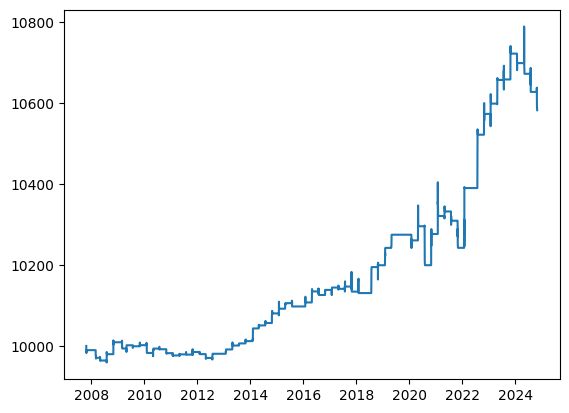

In [647]:
# plot


symbol="MMM"
# AMZN openai/gpt-4o
# add filter by strategy
stock_pred = stocks_predictions_numbers[symbol]
# filter by model
model = "perplexity/llama-3.1-sonar-large-128k-online"
stock_pred = stock_pred[[model]].copy()
# direction is just sign of the number


# drop zeros
stock_pred['direction'] = stock_pred[model].dropna().astype(int).map({
    -2: -1,
    -1:-1,
    0: np.nan,
    1: 1,
    2: 1
})
# filter nans
stock_pred = stock_pred.sort_index().dropna()
#display(stock_pred)

# different timeframes
timeframe = pd.Timedelta(days=5)

def sizing_strategy(current_pos, price_stock, price_spy, beta):
    return 10#current_pos/price_stock


output = backtest(prices[symbol],spy_prices, stock_pred, timeframe, sizing_strategy,current_pos=10000)
display(output)


to_plot = output#.iloc[:9]
# plot current_pos
# plot price_stock on separate y axis

import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
ax1.plot(to_plot.index, to_plot['current_pos'])
#ax2 = ax1.twinx() 

#ax2.plot(to_plot.index, to_plot['price_spy'],color='red')
plt.show()

In [ ]:
# questions interesting to answer
# - short correct 
# - combined model 

In [624]:
stocks_predictions_numbers['AAPL']

,openai/gpt-4o,openai/o1-mini,perplexity/llama-3.1-sonar-large-128k-online,google/gemini-flash-1.5-8b,mistralai/ministral-8b
2005-10-13 14:45:00,0,0,-1,0,0
2006-10-19 00:15:00,1,1,1,2,-1
2006-07-19 19:45:00,1,1,1,1,0
2006-04-20 17:00:00,1,1,1,1,2
2006-01-19 07:45:00,1,2,1,2,1
...,...,...,...,...,...
2023-02-02 08:00:00,0,1,1,-1,2
2024-10-31 17:00:00,1,1,1,1,0
2024-08-01 17:00:00,1,2,1,2,1
2024-05-02 17:00:00,1,1,1,1,-1


In [625]:
spy_series

,price
date,
2000-01-03 09:30:00,148.25
2000-01-03 16:00:00,145.44
2000-01-04 09:30:00,143.53
2000-01-04 16:00:00,139.75
2000-01-05 09:30:00,139.94
...,...
2025-01-06 16:00:00,595.36
2025-01-07 09:30:00,597.42
2025-01-07 16:00:00,588.63


In [632]:
spy_series = convert_to_price_series(spy_prices.copy(),additional_columns=[])
stock_series = convert_to_price_series(prices['NVDA'].copy(),additional_columns=['beta'])




series = stock_series.join(spy_series,lsuffix='_stock',rsuffix='_spy')
stock_pred = stock_pred[stock_pred.index >= series.index[0]].copy()


enter_idx = series.index.searchsorted(stock_pred.index)
leave_idx = series.index.searchsorted(stock_pred.index + timeframe)
enter_idx

array([ 1565,  2315,  3585,  3830,  4084,  6603,  7732,  9867, 10001])

In [633]:
series.iloc[enter_idx]

,price_stock,beta,price_spy
date,,,
2008-02-19 16:00:00,0.54850,2.146789,135.52
2009-08-13 16:00:00,0.34575,1.607145,101.57
2012-02-21 16:00:00,0.39813,1.556239,136.47
2012-08-15 09:30:00,0.36600,1.556526,140.64
2013-02-20 09:30:00,0.31500,1.545661,153.14
2018-02-20 16:00:00,6.23000,1.354495,271.40
2020-05-19 09:30:00,8.79000,1.692656,294.35
2024-08-15 16:00:00,122.86000,1.880677,553.07
2024-11-19 16:00:00,147.01000,1.893733,590.30


In [631]:
stock_pred

,mistralai/ministral-8b,direction
2008-02-19 12:52:08,2,1.0
2009-08-13 15:10:57,2,1.0
2012-02-21 13:50:03,2,1.0
2012-08-15 00:00:00,2,1.0
2013-02-20 00:00:00,2,1.0
2018-02-20 13:00:07,2,1.0
2020-05-19 00:00:00,2,1.0
2024-08-15 10:37:07,2,1.0
2024-11-19 11:33:15,2,1.0
